# Objective
In this assignment we ask you to create a program that allows to represent a RGB image with indexed color using a limited number of colors.

In [93]:
#Imports
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [94]:
def plt_format(image: any) -> any:
    """Function that uses the cvtcolor function from openCV to map the openCV-decoded image (B,G,R) into a regular (R,G,B) format by re-ordering the pixel channels"""
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# A) Define a universal color table with a maximum of 256 different colors

In order to do that, we'll create a color map of 256 colors.\
In RGB, We have 256 * 256 * 256 colors: 3 channels (Red, Green, blue) of one byte (2**8 = 256).\
\
We want to 'downscale' an image by storing every pixel as the index of a Cmap - so every pixel becomes log2(N), with N the colors of the Cmap. With 256 colors, we need 8 bits per pixel - we thus reduce by 3 the size of the image (While loosing information).

## Choice of Cmap
The usual RGB channels are 8 bits each. We want to transfer these 24 bits into 8 bits. In order to do that, we simply restrain the domain of each color: RGB (8,8,8) becomes RGB(3,3,2). With respectively 3,3 and 2 bits, this encoding is 8bits long and thus can create 256 colors.\
For ease of use, we want to stay in the RGB encoding. The new red and green channels can go from 0-7, and the new blue channel go from 0-3. However, takaing this encoding as the direct pixel intensity with limited range (0-7/0-3) are really not adapted to the RGB domain (0-256). In order to cover the full RGB domain, the Cmap colors are scaled up across the whole range.

### Example for the red colors:
The third channel, Blue, is on 2 bits. The intensity encoded are 0-3. In order to span the full domain, the difference between the target domain's length (2\*\*8) and the source domain/s length (2\*\*2) is computed.\
This scale factor represents the jump / step that each point has to make in order to be evenly placed whithin the new domain. In the case of blue, to span 0-256, each of the 4 points must be separated by 64 units of intensity.\
Each point of the new encoding will go from ```(0,X,X), (1,X,X), (2,X,X), (3,X,X)``` --> ```(0,X,X), (64,X,X), (128,X,X), (192,X,X)```\
\
This is done to reach as much of the RGB domain as possible with very little colors. The domain is then evenly covered, but the encoding is **very sparse**. A heavy loss of details is expected.

[(0.0, 0.0, 0.0), (0.0, 0.0, 64.0), (0.0, 0.0, 128.0), (0.0, 0.0, 192.0), (0.0, 32.0, 0.0)]


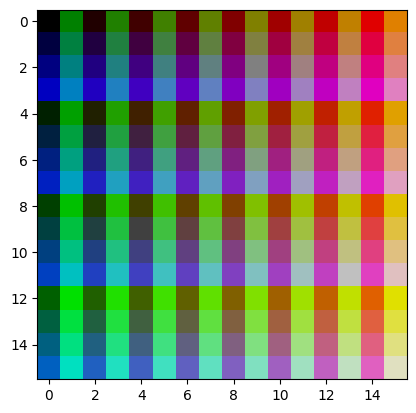

In [95]:
COLORS_NUMBER = 256 #2**8
channels = 3
table_size = int(np.sqrt(COLORS_NUMBER))
colorMatrix = np.zeros((table_size, table_size, channels), np.uint8)
colorTable = []

#Initialize color table
#Say we want to color code in 256 colors - that is, 8 bits
#We can simply assigns (3,3,2) bits for (r,g,b)
#Let's create the table with the combination of every rgb color we can have
index = 0
for r in range(2**3):
    for g in range(2**3):
        for b in range(2**2):
            x = int(index / table_size)
            y = int(index % table_size)
            #Adjust to color space: from 32 colors in a 256-colors space will be spread and not in 0-32
            adjustedColor = (r*(256/2**3), g*(256/2**3), b*(256/2**2))
            colorMatrix[y,x] = adjustedColor
            colorTable.append(adjustedColor)
            index += 1

#Print first 5 pixels
print(colorTable[:5])

#cizualise color table
plt.imshow(colorMatrix)

# Discussion on the Cmap
The color map covers a wide range of colors and shall be able to downscale an image with as little deformations as possible.\
\
There are 2 major discussions to make about the encoding choice:

## The not-so-even distribution
The first point that can be made is that the resulting distribution is not even: the colors are scaled up to [0;2\*\*\[. This means that white (with full colors, (256,256,256)) can never be reached. This is clearly visible on the Cmap above.\
Another choice could be to input the colors Min and Max and to then spread evenly the points in the middle of them - which is what a linear scale does on numpy for example.

## Encoding useless colors
The Cmap is evenly spread across the RGB spectrum - this means:\
+ This Cmap is very versatile and should be OK at encoding a wide range of high-contrast images
+ Computing the Cmap is very efficient (computed once, used everywhere) and the reverse function is direct: a pixel from RGB can be directly mapped by a function to its bucket pixel on the new 8bits domain. This means that encoding an immage in the Cmap is in o(n). With a general Cmap, encoding an image to its index-image is done via a distance function that must be computed to every color of the Cmap in o(n*m) with n the pixels of the image and m the color count of the Cmap.
- This Cmap encodes colors that might not be used at all (losing bits)
- This Cmap has equal jumps between colors, meaning that it is very inneficient for images encoded with very specific colors. For example, a very detailed image heavily in the blue; red or green range will be badly encoded as most of the detailed pixels will be transfered to the same bucket on the Cmap

Creating a Cmap per image would mean that the image size is divided by 3 (on the same one-byte RGB) + an additional 256*8bits for the Cmap itself. This is still a heavy reduction in size as the Cmap size is fixed and not depneding on the image size.\
\
I expect that creating a specilized Cmap would be a similar excersise as computing centroids in machine learning or doing a thresholding: From the image, we could compute the histogram of pixels and separate them into 256 groups of the mostly represented pixels. This way, we could have buckets that are not evenly distributed for RGB but that are present on the most used subdomain of the specific image. Unfortunately, I have no time to experiment with that now.

# (b) Write an algorithm that transforms the initial pixel values with an index to the colortable so that the return image looks as similar as possible to the original image.

In [96]:
MAX_RGB = 2**8
MAX_RG = 2**3
MAX_B = 2**2

def rgb_to_index(x,y,z) -> tuple[int, int, int]:
    """maps an RGB color encoded in the standard (256, 256, 256) notation to its index of the color table encoded in a (8,8,4) world
    This means that from three channels as (8,8,8) bits, we go to 3 channels as (3,3,2) bits, with 2**8 different colors instead of ((2**8)**3)"""
    #get index of the pixel in the (8,8,4) world without the spreading coefficient
    #This means that xindex can be any number between 0-7, but will not be adjusted to the 0-255 plage
    xIndex = np.floor((x / MAX_RGB) * MAX_RG)
    yIndex = np.floor((y / MAX_RGB) * MAX_RG)
    zIndex = np.floor((z / MAX_RGB) * MAX_B)

    #From the x.y.z index, it is easy to compute the index of the color table as we know it has been filled with 
    return int(xIndex*(MAX_RG*MAX_B) + yIndex*MAX_B + zIndex)

#Test the reverse function
colorsToTest = [(64,0,0),(0,64,0), (200,200,200), (220,220,191)]
for color in colorsToTest:
    index = rgb_to_index(*color)
    print(f"Color{color} at index {index} of the color table: table[{index}]={colorTable[index]}")

Color(64, 0, 0) at index 64 of the color table: table[64]=(64.0, 0.0, 0.0)
Color(0, 64, 0) at index 8 of the color table: table[8]=(0.0, 64.0, 0.0)
Color(200, 200, 200) at index 219 of the color table: table[219]=(192.0, 192.0, 192.0)
Color(220, 220, 191) at index 218 of the color table: table[218]=(192.0, 192.0, 128.0)


# (c) Optionally, replace the universal color table by an adaptive colour table, which is optimized for the given input image.

I have no time to do this unfortunately, although I explained my rationale on how I would approach it on the previous paragraph (discussions on the Cmap).\
TL;DR: I would do a histogram and take the 256 'most representative' pixels (ex: centroid algorithm) as my indexed colors insted of the evenly-distributed used here.

# Image transfer
Create a function that does this simple transfer of an image into its encoding and display the results with the color map

In [97]:
def work(imageName, save: bool = False):
    #Load the image as a 2D array of 3 channels
    image = cv2.imread(f'./in/{imageName}') 
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    #Using the previously developped function, map each pixel to its "bucket" representation as an index of the color table
    y,x,z = image.shape

    #Image as a list of index
    imageAsIndexes = np.zeros((x,y), int)
    for i in range(x):
        for j in range(y):
            imageAsIndexes[i, j] = rgb_to_index(*image[i,j])

    #Image as in the color table
    colorMapImage = np.zeros(image.shape, np.uint8)
    for i in range(x):
        for j in range(y):
            index = imageAsIndexes[i,j]
            colorMapImage[i, j] = colorTable[index]

    y,x,z = image.shape
    print(f"Image is {x}*{y} pixels, pixels have {z} channels")
    print(f"Size of the original image: {(x*y*z)/1000} Mbytes")

    yIndex, xIndex = imageAsIndexes.shape
    print(f"Image is {xIndex}*{yIndex} pixels, pixels have 1 channel")
    print(f"Size of the original image: {(xIndex*yIndex)/1000} MBytes")


    #Display first image and color image, as well as Cmap
    fig, axes = plt.subplots(1, 3, figsize=(15, 7))
    fig.suptitle(f'Image {imageName} encoded with a generic Cmap', fontweight='bold')

    axes[0].imshow(image)
    axes[0].set_title('Original image')
    axes[0].set_axis_off()

    axes[1].imshow(colorMapImage)
    axes[1].set_title('Colormap-transformed image')
    axes[1].set_axis_off()


    axes[2].imshow(colorMatrix)
    axes[2].set_title('Color map')
    axes[2].set_axis_off()

    if save:
        cv2.imwrite("./out/lena_orig.png", cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
        cv2.imwrite("./out/lena_indexed.png", cv2.cvtColor(colorMapImage, cv2.COLOR_RGB2BGR))
        cv2.imwrite("./out/cmap.png", cv2.cvtColor(colorMatrix, cv2.COLOR_RGB2BGR))

        with open('./out/cmap.txt', 'w') as txt_file:
            for line in colorMatrix:
                line_str = [f"({r:03},{g:03},{b:03})" for (r,g,b) in line] # create string list from integer list
                txt_file.write(" | ".join(line_str) + "\n")

        with open('./out/indexedImage.txt', 'w') as txt_file:
            for line in imageAsIndexes:
                line_str = [f"{n:03}" for n in line] # create string list from integer list
                txt_file.write(" | ".join(line_str) + "\n")

# First test with Lena
Save the result in order to deliver it

Image is 256*256 pixels, pixels have 3 channels
Size of the original image: 196.608 Mbytes
Image is 256*256 pixels, pixels have 1 channel
Size of the original image: 65.536 MBytes


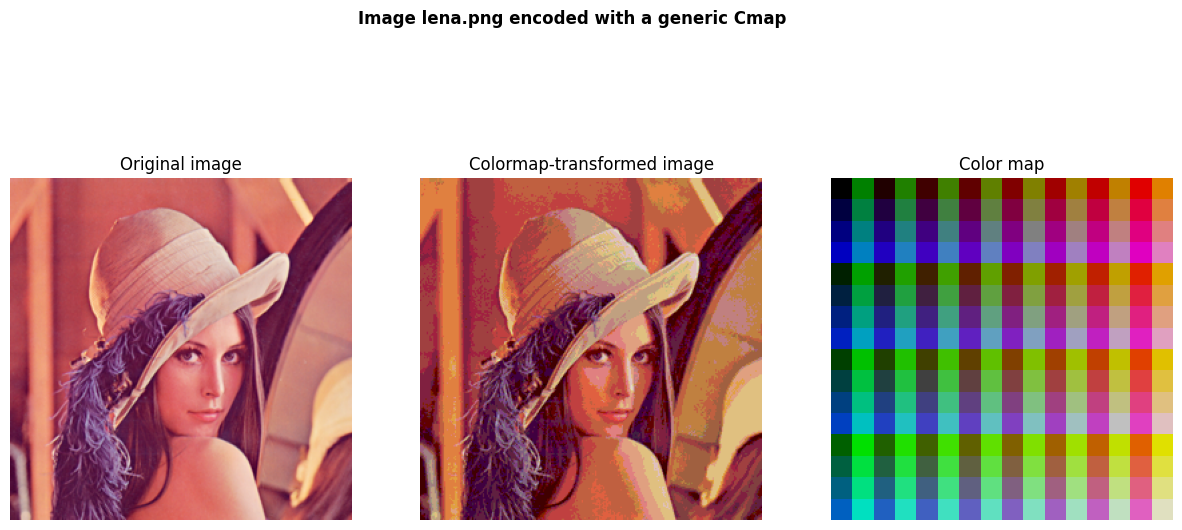

In [98]:
work('lena.png', save=True)

Tests with every image

Image is 256*256 pixels, pixels have 3 channels
Size of the original image: 196.608 Mbytes
Image is 256*256 pixels, pixels have 1 channel
Size of the original image: 65.536 MBytes
Image is 256*256 pixels, pixels have 3 channels
Size of the original image: 196.608 Mbytes
Image is 256*256 pixels, pixels have 1 channel
Size of the original image: 65.536 MBytes
Image is 256*256 pixels, pixels have 3 channels
Size of the original image: 196.608 Mbytes
Image is 256*256 pixels, pixels have 1 channel
Size of the original image: 65.536 MBytes
Image is 256*256 pixels, pixels have 3 channels
Size of the original image: 196.608 Mbytes
Image is 256*256 pixels, pixels have 1 channel
Size of the original image: 65.536 MBytes


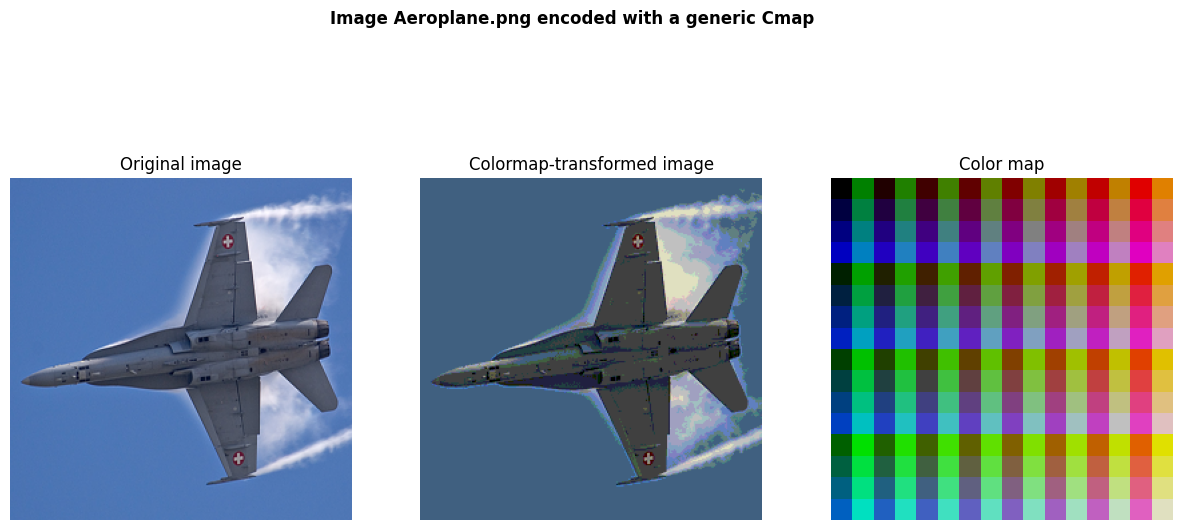

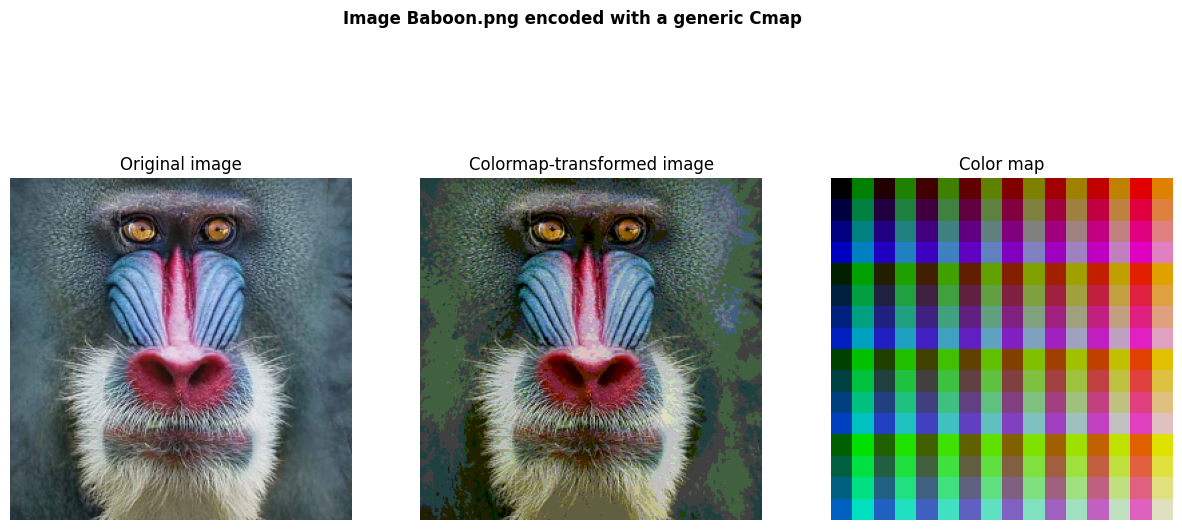

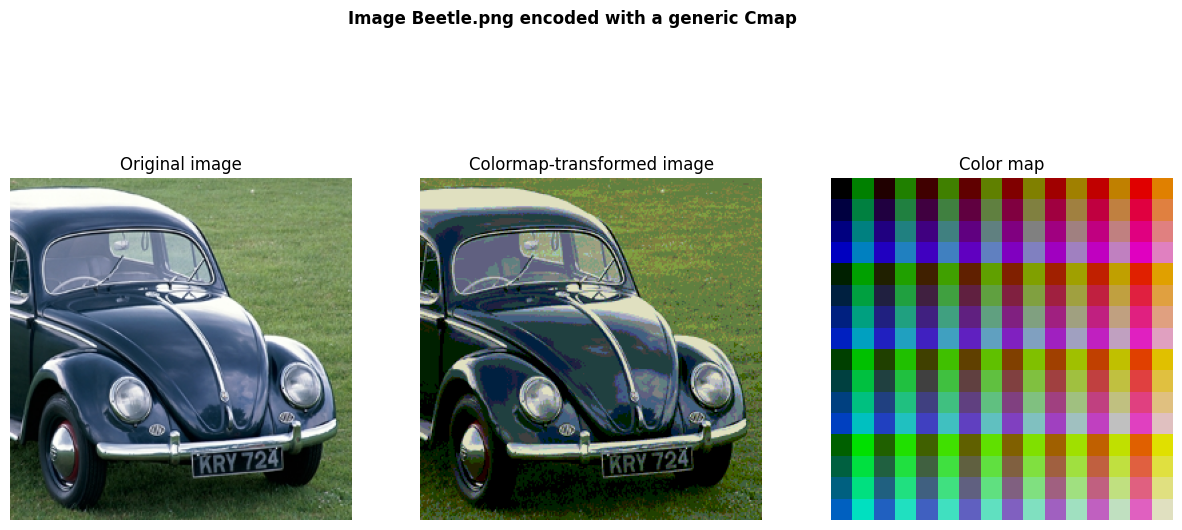

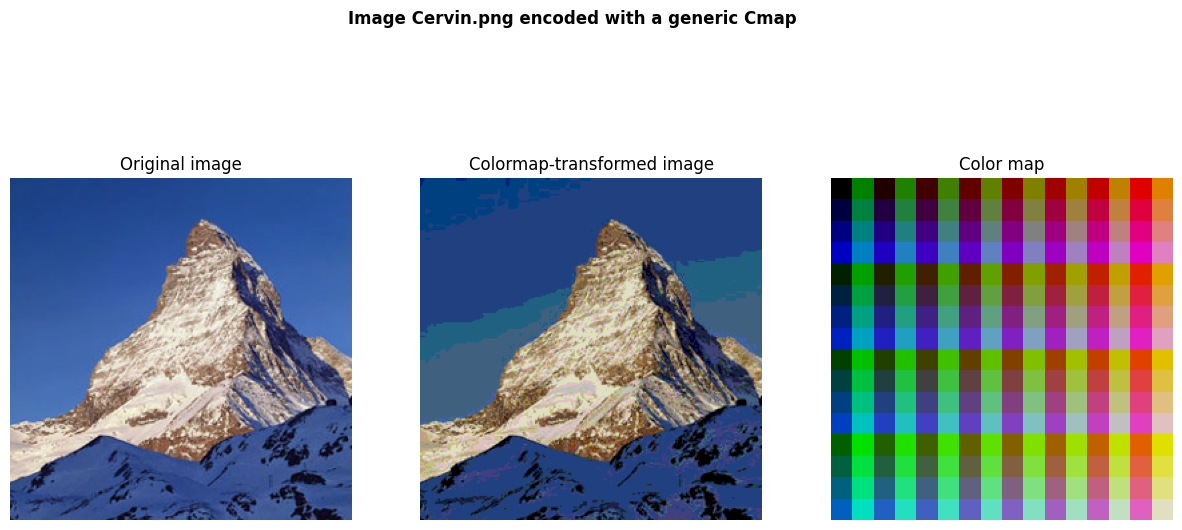

In [99]:
for imageName in ["Aeroplane.png", "Baboon.png", "Beetle.png", "Cervin.png"]:
    work(imageName)